***IMPORTS***

In [1]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=13207e512db40ed4a6ede76997220dd24dcd02bfa893ba4e75737b116a1759ca
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [2]:
import pandas as pd
import numpy as np
import csv
import re
import string
from collections import defaultdict

import eli5

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

***LOADING THE DATASET***

In [3]:
# download dataset
!gdown 1QP6YuwdKFNUPpvhOaAcvv2Pcp4JMbIRs # x_train
!gdown 1QVo7PZAdiZKzifK8kwhEr_umosiDCUx6 # x_test
!gdown 1QbBeKcmG2ZyAEFB3AKGTgSWQ1YEMn2jl # y_train
!gdown 1QaZj6bI7_78ymnN8IpSk4gVvg-C9fA6X # y_test

Downloading...
From: https://drive.google.com/uc?id=1QP6YuwdKFNUPpvhOaAcvv2Pcp4JMbIRs
To: /content/x_train.txt
100% 64.1M/64.1M [00:00<00:00, 94.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QVo7PZAdiZKzifK8kwhEr_umosiDCUx6
To: /content/x_test.txt
100% 65.2M/65.2M [00:00<00:00, 99.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QbBeKcmG2ZyAEFB3AKGTgSWQ1YEMn2jl
To: /content/y_train.txt
100% 480k/480k [00:00<00:00, 25.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QaZj6bI7_78ymnN8IpSk4gVvg-C9fA6X
To: /content/y_test.txt
100% 480k/480k [00:00<00:00, 55.4MB/s]


In [4]:
with open(f'x_train.txt') as f:
    x_train = f.read().splitlines()
with open(f'y_train.txt') as f:
    y_train = f.read().splitlines()
with open(f'x_test.txt') as f:
    x_test = f.read().splitlines()
with open(f'y_test.txt') as f:
    y_test = f.read().splitlines()

In [5]:
# combine x_train and y_train into one dataframe
train_df = pd.DataFrame({'text': x_train, 'label': y_train})
# write train_df to csv with tab as separator
train_df.to_csv('train_df.csv', index=False, sep='\t')
# comibne x_test and y_test into one dataframe
test_df = pd.DataFrame({'text': x_test, 'label': y_test})

***EXPLORATORY DATA ANALYSIS (EDA)***

In [6]:
# T: Have a quick peek at the training data, looking at a couple of texts from different languages. Do you notice anything that might be challenging for the classification?

In [7]:
train_df.head()

,text,label
0,Klement Gottwaldi surnukeha palsameeriti ning ...,est
1,"Sebes, Joseph; Pereira Thomas (1961) (på eng)....",swe
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai
3,"Après lo cort periòde d'establiment a Basilèa,...",oci
4,ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...,tha




1.Some languages may share similar words, phrases, or sentence structures, making it challenging to differentiate between them.


2.Code-mixing, which involves mixing multiple languages within a single sentence or text, can pose challenges for language classification

3.Working with languages that use non-Latin scripts can introduce additional complexities for language classification


In [8]:
# Number of samples per language
print(train_df['label'].value_counts())

est    500
eng    500
vep    500
sgs    500
uig    500
      ... 
lmo    500
mya    500
ilo    500
csb    500
ltz    500
Name: label, Length: 235, dtype: int64


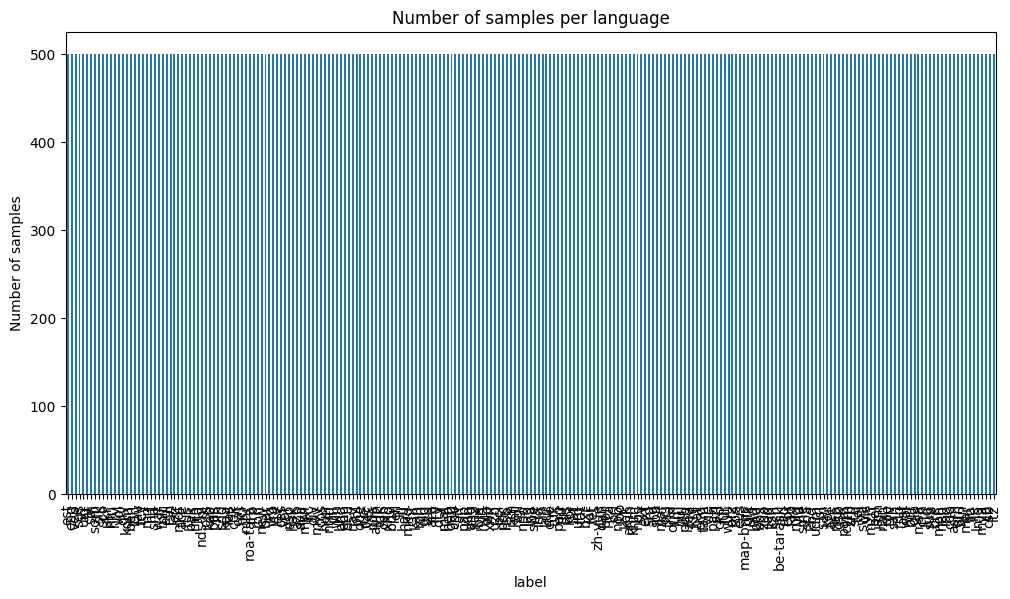

In [9]:
# Bar chart showing the number of samples per language

plt.figure(figsize=(12, 6))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Number of samples per language')
plt.ylabel('Number of samples')
plt.xlabel('label')
plt.show()

In [10]:
# T: How many instances per label are there in the training and test set?
# Do you think this is a balanced dataset?
# Do you think the train/test split is appropriate?
# If not, please rearrange the data in a more appropriate way.

# Count instances per label in the training set
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
instances_per_label_train = dict(zip(unique_labels_train, counts_train))
print("Instances per label in the training set:", instances_per_label_train)

# Count instances per label in the test set
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
instances_per_label_test = dict(zip(unique_labels_test, counts_test))
print("Instances per label in the test set:", instances_per_label_test)

# Dataset is balanced
# There are 500 instances per label in both sets

# train and test set are split 50/50
print(len(x_train))
print(len(x_test))


Instances per label in the training set: {'ace': 500, 'afr': 500, 'als': 500, 'amh': 500, 'ang': 500, 'ara': 500, 'arg': 500, 'arz': 500, 'asm': 500, 'ast': 500, 'ava': 500, 'aym': 500, 'azb': 500, 'aze': 500, 'bak': 500, 'bar': 500, 'bcl': 500, 'be-tarask': 500, 'bel': 500, 'ben': 500, 'bho': 500, 'bjn': 500, 'bod': 500, 'bos': 500, 'bpy': 500, 'bre': 500, 'bul': 500, 'bxr': 500, 'cat': 500, 'cbk': 500, 'cdo': 500, 'ceb': 500, 'ces': 500, 'che': 500, 'chr': 500, 'chv': 500, 'ckb': 500, 'cor': 500, 'cos': 500, 'crh': 500, 'csb': 500, 'cym': 500, 'dan': 500, 'deu': 500, 'diq': 500, 'div': 500, 'dsb': 500, 'dty': 500, 'egl': 500, 'ell': 500, 'eng': 500, 'epo': 500, 'est': 500, 'eus': 500, 'ext': 500, 'fao': 500, 'fas': 500, 'fin': 500, 'fra': 500, 'frp': 500, 'fry': 500, 'fur': 500, 'gag': 500, 'gla': 500, 'gle': 500, 'glg': 500, 'glk': 500, 'glv': 500, 'grn': 500, 'guj': 500, 'hak': 500, 'hat': 500, 'hau': 500, 'hbs': 500, 'heb': 500, 'hif': 500, 'hin': 500, 'hrv': 500, 'hsb': 500, 'hun

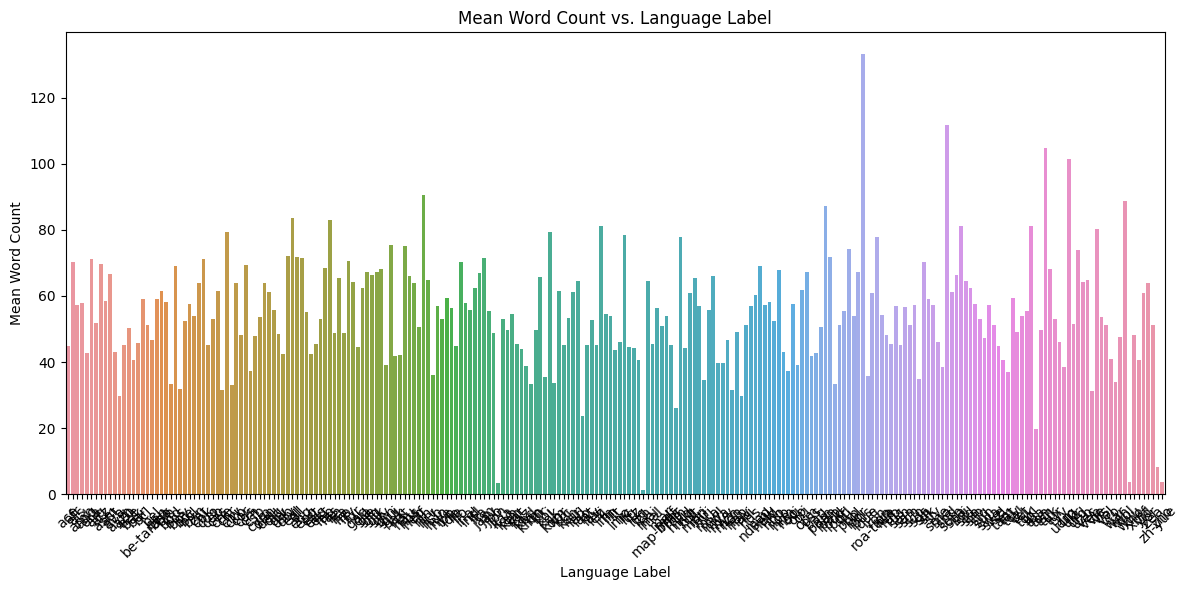

In [11]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
mean_word_counts = train_df.groupby('label')['word_count'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='label', y='word_count', data=mean_word_counts)
plt.title('Mean Word Count vs. Language Label')
plt.ylabel('Mean Word Count')
plt.xlabel('Language Label')
plt.xticks(rotation=45)  # Rotates x-axis labels for better visibility if they are long
plt.tight_layout()
plt.show()

***DATA PREPROCESSING***

In [12]:
# The function aims to clean the text data by converting it to lowercase, removing punctuation marks, excess whitespaces and removing numbers.

def preprocess_text(text):
  # Convert all words to lower case
  text = text.lower()
  # Remove all punctuations
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove numbers
  text = re.sub(r'\d+', '', text)
  text = ' '.join(text.split())
  return text

In [13]:
# T: Get a subset of the train/test data that includes English, German, Dutch, Danish, Swedish and Norwegian, plus 20 additional languages of your choice (the labels can be found in the file labels.csv)

# merge test and train dataset in order to rearange it later
frames = [train_df, test_df]
df_combined = pd.concat(frames)


selected_languages = ['eng', 'deu', 'nld', 'dan', 'swe', 'nob', 'est', 'oci', 'zea', 'pnb', 'wuu', 'pan', 'fur','ton', 'glk', 'bod', 'jpn', 'srd', 'ext', 'sin', 'che', 'pag', 'als', 'koi', 'kir', 'bul']
filtered_df = df_combined[df_combined['label'].isin(selected_languages)]

# Define the function to compute average word length
def average_word_length(text):
    words = text.split()
    if len(words) == 0:  # To handle potential empty strings
        return 0
    return sum(len(word) for word in words) / len(words)

# Create a new column 'avg_word_length'. We wanted to add this as a feature for our classification models.
filtered_df['avg_word_length'] = filtered_df['text'].apply(average_word_length)

# Apply the preprocess_text() function to the 'text' column
filtered_df['text'] = filtered_df['text'].apply(preprocess_text)

# Display the updated DataFrame
print(filtered_df.head())

<ipython-input-13-4ca665587b65>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['avg_word_length'] = filtered_df['text'].apply(average_word_length)


                                                text label  word_count  \
0  Klement Gottwaldi surnukeha palsameeriti ning ...   est        46.0   
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....   swe        32.0   
3  Après lo cort periòde d'establiment a Basilèa,...   oci       160.0   
8  براعظم ایشیاء تے یورپ اتے پھیلے ہوئے دیس ترکی ...   pnb        45.0   
9  Vanwehe zen Gentsen ofkomst wor 't een ok wè G...   zea        52.0   

   avg_word_length  
0         6.956522  
1         5.718750  
3         5.718750  
8         3.400000  
9         4.692308  
                                                text label  word_count  \
0  klement gottwaldi surnukeha palsameeriti ning ...   est        46.0   
1  sebes joseph pereira thomas på eng the jesuits...   swe        32.0   
3  après lo cort periòde destabliment a basilèa t...   oci       160.0   
8  براعظم ایشیاء تے یورپ اتے پھیلے ہوئے دیس ترکی ...   pnb        45.0   
9  vanwehe zen gentsen ofkomst wor t een ok wè ga...   zea 

<ipython-input-13-4ca665587b65>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['text'].apply(preprocess_text)


In [14]:
# Split the DataFrame into text (X) and label (y)
X = filtered_df[['text', 'avg_word_length']]
# X = filtered_df['text']
y = filtered_df['label']


# Split the data into training and test datasets 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#for a subset with 26 languages and 80/20 split we should have 5200 instances in the X_test set and 20800 in the X_train
print(len(X_test))
print(len(X_train))

5200
20800


In [15]:
# T: With the following code, we wanted to encode the labels, however, our cat was walking on the keyboard and some of it got changed. Can you fix it?

le_subset = LabelEncoder()

y_train_encoded_subset = le_subset.fit_transform(y_train)
y_test_encoded_subset = le_subset.fit_transform(y_test)

# Get the encoded classes
encoded_classes = le_subset.classes_
print("Encoded classes:", encoded_classes)

Encoded classes: ['als' 'bod' 'bul' 'che' 'dan' 'deu' 'eng' 'est' 'ext' 'fur' 'glk' 'jpn'
 'kir' 'koi' 'nld' 'nob' 'oci' 'pag' 'pan' 'pnb' 'sin' 'srd' 'swe' 'ton'
 'wuu' 'zea']


***VECTORIZER, MODEL AND PIPELINE***

In [16]:
# Initialize Vectorizers
char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1, 1))
word_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))

# Helper transformer to reshape data
def reshape_data(X):
    return X.values.reshape(-1, 1)

reshaper = FunctionTransformer(reshape_data, validate=False)

# Define the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', FeatureUnion([('char', char_tfidf), ('word', word_tfidf)]), 'text'),
        ('word_length', Pipeline([
            ('reshaper', reshaper),
            ('scaler', StandardScaler())
        ]), 'avg_word_length')
    ])

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver="saga", max_iter=20))
])

# # Create a pipeline that uses both chars and words as features

# tfidf = FeatureUnion([('char', char_tfidf), ('word', word_tfidf)])
# pipeline_2 = Pipeline([
#     ('tfidf', tfidf),
#     ('classifier',  LogisticRegression(solver="saga", max_iter=20))
#     ])

In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train_encoded_subset, scoring='accuracy', cv=5)
scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array([0.96826923, 0.96610577, 0.965625  , 0.96442308, 0.96274038])

In [18]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(pipeline_2, X_train, y_train_encoded_subset, scoring='accuracy', cv=5)
# scores

***GRID SEARCH FOR BEST MODEL***

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2),],
              'tfidf__analyzer': ["char", "word"],
              'tfidf__max_features': [100,200],
              'classifier__penalty': ['l1', 'l2' ],
              'classifier__solver': [ "saga",],
              'classifier__max_iter': [20 ,40 ]

             }

param_grid2 = {
    'preprocessor__text__char__ngram_range': [(1, 1), (1, 2)],
    'preprocessor__text__word__ngram_range': [(1, 1), (1, 2)],
    #'preprocessor__text__word__max_features': [10,20],
    #'preprocessor__text__char__max_features': [10,20],
    'classifier__penalty': ['l1', 'l2' ],
    'classifier__solver': ["saga",],
    'classifier__max_iter': [20, 40 ]
}

gs_reg = GridSearchCV(pipeline, param_grid2, cv=5, verbose=1)
gs_reg.fit(X_train, y_train_encoded_subset)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         FeatureUnion(transformer_list=[('char',
                                                                                                         TfidfVectorizer(analyzer='char')),
                                                                                                        ('word',
                                                                                                         TfidfVectorizer())]),
                                                                         'text'),
                                                                        ('word_length',
                                                                         Pipeline(steps=[('reshaper',
                                                                                          FunctionTransformer(func=<function reshape_data at 0x7aedb67fb010>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         'avg_word_length')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=20,
                                                           solver='saga'))]),
             param_grid={'classifier__max_iter': [20, 40],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['saga'],
                         'preprocessor__text__char__ngram_range': [(1, 1),
                                                                   (1, 2)],
                         'preprocessor__text__word__ngram_range': [(1, 1),
                                                                   (1, 2)]},
             verbose=1)

In [20]:
reg_df = pd.DataFrame.from_dict(gs_reg.cv_results_)
reg_df.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,param_preprocessor__text__char__ngram_range,param_preprocessor__text__word__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,39.516191,0.459525,1.890828,0.446767,40,l2,saga,"(1, 2)","(1, 1)","{'classifier__max_iter': 40, 'classifier__pena...",0.973077,0.972356,0.971875,0.973798,0.968510,0.971923,0.001827,1
15,62.618226,0.805777,1.938557,0.099899,40,l2,saga,"(1, 2)","(1, 2)","{'classifier__max_iter': 40, 'classifier__pena...",0.971635,0.971154,0.972115,0.970913,0.968750,0.970913,0.001158,2
12,20.509619,0.657872,0.870730,0.266461,40,l2,saga,"(1, 1)","(1, 1)","{'classifier__max_iter': 40, 'classifier__pena...",0.970913,0.970673,0.969231,0.970192,0.966827,0.969567,0.001487,3
6,24.600000,0.698725,1.823309,0.433913,20,l2,saga,"(1, 2)","(1, 1)","{'classifier__max_iter': 20, 'classifier__pena...",0.971875,0.970433,0.969471,0.969231,0.966106,0.969423,0.001901,4
10,105.128175,7.657704,1.894598,0.092574,40,l1,saga,"(1, 2)","(1, 1)","{'classifier__max_iter': 40, 'classifier__pena...",0.969952,0.968269,0.967308,0.968510,0.966106,0.968029,0.001281,5
7,37.457600,0.745777,2.172802,0.401951,20,l2,saga,"(1, 2)","(1, 2)","{'classifier__max_iter': 20, 'classifier__pena...",0.970673,0.968029,0.968750,0.965625,0.965385,0.967692,0.001986,6
13,37.585809,0.660764,1.185399,0.299283,40,l2,saga,"(1, 1)","(1, 2)","{'classifier__max_iter': 40, 'classifier__pena...",0.968510,0.967308,0.965625,0.964904,0.965144,0.966298,0.001388,7
11,146.549422,7.668796,2.446989,0.501379,40,l1,saga,"(1, 2)","(1, 2)","{'classifier__max_iter': 40, 'classifier__pena...",0.967788,0.965865,0.966106,0.964904,0.964423,0.965817,0.001162,8
4,10.762893,0.096267,0.691502,0.022478,20,l2,saga,"(1, 1)","(1, 1)","{'classifier__max_iter': 20, 'classifier__pena...",0.968029,0.966106,0.965625,0.964904,0.962740,0.965481,0.001717,9
2,58.769795,3.647304,2.109465,0.487914,20,l1,saga,"(1, 2)","(1, 1)","{'classifier__max_iter': 20, 'classifier__pena...",0.968269,0.966106,0.964904,0.963462,0.963942,0.965337,0.001723,10


In [26]:
# Printing the best hyperparameter set

print("Best hyperparameters:", gs_reg.best_params_)
print("Best cross-validation score:", gs_reg.best_score_)

Best hyperparameters: {'classifier__max_iter': 40, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'preprocessor__text__char__ngram_range': (1, 2), 'preprocessor__text__word__ngram_range': (1, 1)}
Best cross-validation score: 0.9719230769230769


In [21]:
# #Best Model

# #Create a pipeline that uses both chars and words as features
# char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
# word_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
# tfidf = FeatureUnion([('char', char_tfidf), ('word', word_tfidf)])
# model = Pipeline([
#     ('tfidf', tfidf),
#     ('classifier',  LogisticRegression(solver="saga", penalty="l2"))
#     ])


***MODEL TESTING***

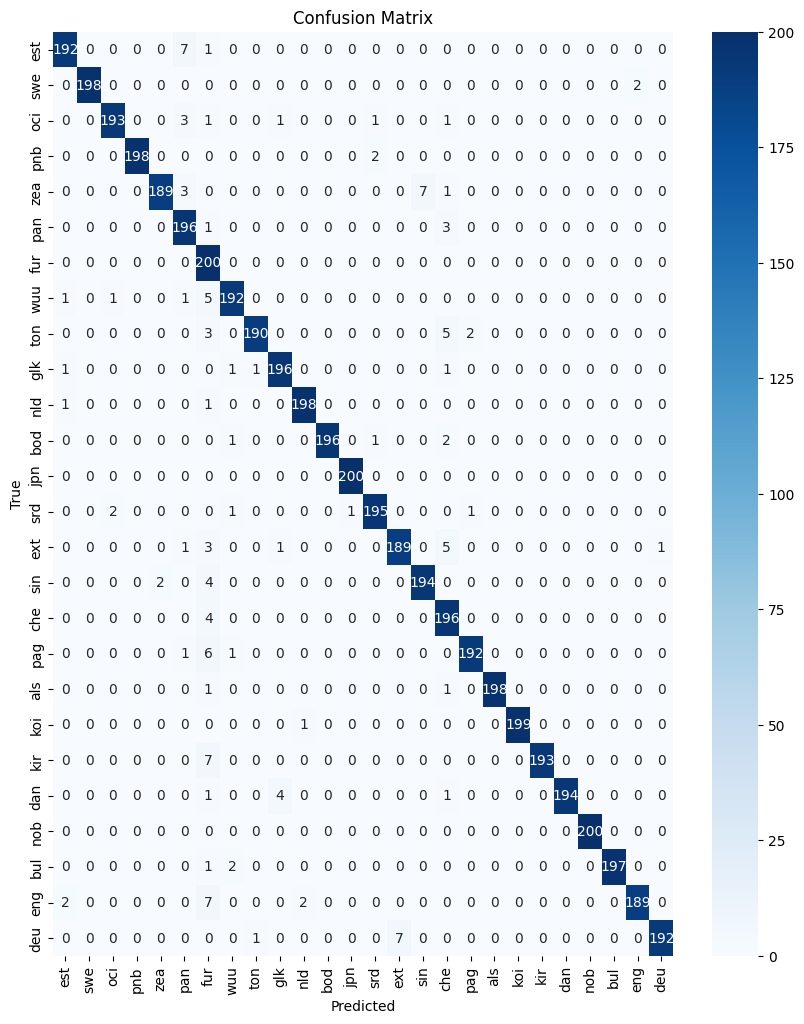

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the test data
y_pred = gs_reg.predict(X_test)

true_labels = y_test
predicted_labels = y_pred

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a figure
plt.figure(figsize=(10, 12))

# get list of filtered labels
labels = filtered_df['label'].unique().tolist()

# Plot the heatmap matrix as an image
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('True')

# Set the title
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [28]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9742


***FEATURE IMPORTANCE WITH ELI5***

In [40]:
import eli5

best_model = gs_reg.best_estimator_

In [55]:
transformer = best_model.named_steps['preprocessor']
char_vectorizer = transformer.named_transformers_['text'].transformer_list[0][1]
word_vectorizer = transformer.named_transformers_['text'].transformer_list[1][1]

other_features = ["avg_word_length"]

char_features = ["char_" + name for name in char_vectorizer.get_feature_names_out()]
word_features = ["word_" + name for name in word_vectorizer.get_feature_names_out()]

feature_names = char_features + word_features + other_features

In [57]:
eli5.show_weights(best_model.named_steps['classifier'],
                  feature_names=feature_names)

In [ ]:
# # Fit the pipeline on the training data
# filtered_df = df_combined[
#     (df_combined['label']== "eng")
#     |(df_combined['label']== "nob")
#     |(df_combined['label']== "swe")
#     |(df_combined['label']== "jpn")

#     ]
# # Split the DataFrame into tsext (X) and label (y)
# X = filtered_df['text']
# y = filtered_df['label']


# # Split the data into training and test datasets 80/20
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# gs_reg.fit(X_train, y_train)

In [24]:
# # Get the feature importance table using eli5
# feature_names = model.named_steps['tfidf'].get_feature_names_out()
# feature_importances = eli5.explain_weights_df(model.named_steps['classifier'],
#                                            vec=model.named_steps['tfidf'],
#                                             feature_names=feature_names,
#                                            top=10)
# from IPython.display import display
# # displaying the DataFrame
# display(feature_importances)

***ABLATION STUDY***

In [75]:
with open(f'x_train.txt') as f:
    x_train = f.read().splitlines()
with open(f'y_train.txt') as f:
    y_train = f.read().splitlines()
with open(f'x_test.txt') as f:
    x_test = f.read().splitlines()
with open(f'y_test.txt') as f:
    y_test = f.read().splitlines()

# combine x_train and y_train into one dataframe
train_df = pd.DataFrame({'text': x_train, 'label': y_train})
# write train_df to csv with tab as separator
train_df.to_csv('train_df.csv', index=False, sep='\t')
# comibne x_test and y_test into one dataframe
test_df = pd.DataFrame({'text': x_test, 'label': y_test})

frames = [train_df, test_df]
df_combined = pd.concat(frames)


selected_languages = ['nob', 'jpn']
filtered_df = df_combined[df_combined['label'].isin(selected_languages)]

# Create a new column 'avg_word_length'. We wanted to add this as a feature for our classification models.
filtered_df['avg_word_length'] = filtered_df['text'].apply(average_word_length)

# Apply the preprocess_text() function to the 'text' column
filtered_df['text'] = filtered_df['text'].apply(preprocess_text)

# Display the updated DataFrame
print(filtered_df.head())

                                                  text label  avg_word_length
29   エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと運...   jpn       250.000000
46   シャーリー・フィールドは、サン・ベルナルド・アベニュー沿い市民センターとrtマーティン高校に...   jpn       266.000000
58   mens harrison forberedte sin turne i los angel...   nob         4.842697
142  indias utøvere konkurrerte først under det oly...   nob         6.000000
225  藤女の女性教師。歳。数学担当。風紀指導を担当しており、リコにとっては天敵。藤女とその伝統に強...   jpn       213.000000


<ipython-input-75-e9d7b66bef98>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['avg_word_length'] = filtered_df['text'].apply(average_word_length)
<ipython-input-75-e9d7b66bef98>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['text'].apply(preprocess_text)


In [79]:
# Split the data into training and test datasets 80/20
X_train, X_test, y_train, y_test = train_test_split(filtered_df[["text", "avg_word_length"]], filtered_df["label"], test_size=0.2, random_state=42, stratify=y)

In [86]:
X_train.describe

<bound method NDFrame.describe of                                                      text  avg_word_length
112787  skottland har et omfattende jernbanenettverk o...         5.945455
115196  ledere trener og øvrig støtteapparat for den n...         5.761905
117148  京都市バス等持院道バス停徒歩すぐところに位置する。地上階建。寮室室、アクセシブルルーム室、ゲ...       147.000000
28205   独立行政法人国立病院機構別府医療センター（どくりつぎょうせいほうじんこくりつびょういんきこう...       212.000000
2406    til india hører også tre små øygrupper lakshad...         6.047619
...                                                   ...              ...
60408   på denne tiden var ikke fredrik iv av danmarkn...         4.803150
105990  近代京都建築を手本に設計され、外壁には輸入英国製煉瓦、屋根部分は緑青銅版、白壁部分はテラコッ...        94.500000
62644   etter mordet på aleksander ii i ble han utnevn...         5.583333
74979   siljan har flere ganger blitt kåret til telema...         5.240000
5199    bilen leveres med enten hk bensinmotor eller h...         6.071429

[1600 rows x 2 columns]>

In [99]:
# Get the hyperparameters of the best performing model

best_params = gs_reg.best_params_

# Initialize Vectorizers
char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=best_params['preprocessor__text__char__ngram_range'])
word_tfidf = TfidfVectorizer(analyzer='word', ngram_range=best_params['preprocessor__text__word__ngram_range'])

# Helper transformer to reshape data
def reshape_data(X):
    return X.values.reshape(-1, 1)

reshaper = FunctionTransformer(reshape_data, validate=False)

# Define the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', FeatureUnion([('char', char_tfidf), ('word', word_tfidf)]), 'text'),
        ('word_length', Pipeline([
            ('reshaper', reshaper),
            ('scaler', StandardScaler())
        ]), 'avg_word_length')
    ])

# Create the pipeline
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=best_params['classifier__penalty'], solver="saga", max_iter=best_params["classifier__max_iter"]))
])

In [139]:
from sklearn.metrics import classification_report
from sklearn.base import clone

# Define the character limits for the ablation study
character_limits = [1600, 500, 100]

for limit in character_limits:

    current_pipeline = clone(best_pipeline)

    # Trim the 'text' column in X_train to the specified character limit
    X_train_trimmed = X_train.copy()
    X_train_trimmed['text'] = X_train_trimmed['text'].str[:limit]

    # Fit the pipeline to the trimmed training data
    current_pipeline.fit(X_train_trimmed, y_train)

    # Predict the language labels for the test data
    y_pred = current_pipeline.predict(X_test)

    # Evaluate the model performance
    print(f"Character Limit: {limit}")
    print(accuracy_score(y_test, y_pred))
    print("----------------------")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Character Limit: 1600
0.9875
----------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Character Limit: 500
0.9875
----------------------
Character Limit: 100
0.99
----------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [138]:
# Define the character limits for the ablation study
character_limits = [1600, 100, 5]

for limit in character_limits:

    current_pipeline = clone(best_pipeline)

    # Trim the 'text' column in X_train to the specified character limit
    X_train_trimmed = X_train.copy()
    X_train_trimmed['text'] = X_train_trimmed['text'].str[:limit]

    # Fit the pipeline to the trimmed training data
    current_pipeline.fit(X_train_trimmed, y_train)

    # Predict the language labels for the test data
    y_pred = current_pipeline.predict(X_test)

    # Evaluate the model performance
    print(f"Character Limit: {limit}")
    print(accuracy_score(y_test, y_pred))
    print("----------------------")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Character Limit: 1600
0.9875
----------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Character Limit: 100
0.99
----------------------
Character Limit: 5
0.97
----------------------
